In [ ]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Global parameters
#root folder
root_folder='.'
#data_folder='.'
#data_folder_name='content'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 15  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [ ]:
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial
# in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [ ]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[15000])
print(target_data[15000])
print(target_input_data[15000])

she didn t answer .
ella no respondio . <eos>
<sos> ella no respondio .


In [ ]:
#See why we use filter
dummy=['I am Raj .']
t=Tokenizer()
t.fit_on_texts(dummy)
t.texts_to_sequences(dummy)

[[1, 2, 3]]

In [ ]:
# Create a tokenizer for the input texts and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[15000])
print(input_sequences[15000])

Max Input Length:  8
she didn t answer .
[27, 90, 10, 238, 1]


In [ ]:
# tokenize the outputs
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[15000])
print(target_sequences[15000])
print(target_input_data[15000])
print(target_sequences_inputs[15000])

Max Target Length:  15
ella no respondio . <eos>
[29, 8, 831, 1, 2]
<sos> ella no respondio .
[3, 29, 8, 831, 1]


In [ ]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 3664 unique input tokens.
Found 7168 unique output tokens.


In [ ]:
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (20000, 8)
encoder_inputs[0]: [31  1  0  0  0  0  0  0]
decoder_inputs[0]: [ 3 99  1  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 15)


In [ ]:
len(input_data)==len(target_data)==len(target_input_data)

True

**Max_len of target data & target_input data is the same since each has eos OR sos**


In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_inputs, decoder_targets))
for element in dataset:
  print(element)
  print(len(element))
  print(type(element[0]))
  print(type(element[1]))
  print(type(element[2]))
  break
#Just to see what the generator gives

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([31,  1,  0,  0,  0,  0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(15,), dtype=int32, numpy=
array([ 3, 99,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)>, <tf.Tensor: shape=(15,), dtype=int32, numpy=
array([99,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)>)
3
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)
#Drop remainder=True drops batches with size < batch_size

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    # Define the embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Define the RNN layer, LSTM
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True)

  def call(self,input_sequence,states):
    #Embed input sequence
    embed=self.embedding(input_sequence) 
    #LSTM
    output, state_h, state_c = self.lstm(embed, initial_state=states) #h-memory c-carry
    return output, state_h, state_c

  def init_states(self, batch_size):
    # Return a all 0s initial states
    return (tf.zeros([batch_size, self.hidden_dim]),tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Decoder,self).__init__()
    self.hidden_dim=hidden_dim
    self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True)
    self.dense=tf.keras.layers.Dense(vocab_size)

  def call(self,input_sequence,state_tuple):
    embed=self.embedding(input_sequence)
    lstm_out,state_h,state_c=self.lstm(embed, initial_state=state_tuple)
    logits=self.dense(lstm_out) #Softmax is covered in the loss function
    return logits, state_h, state_c

In [ ]:
print("Embedding dimension "+str(EMBEDDING_DIM))
print("Hidden dimension "+str(HIDDEN_DIM))
print("Batch Size "+str(BATCH_SIZE))

Embedding dimension 128
Hidden dimension 1024
Batch Size 64


In [ ]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_outputs = len(word2idx_outputs) + 1

encoder=Encoder(num_words_inputs,EMBEDDING_DIM,HIDDEN_DIM)

initial_states = encoder.init_states(1) # 1 X 1024 (HIDDEN_DIM). All zeroes

test_encoder_output = encoder(tf.constant([[1, 23, 4, 5, 0, 0]]), initial_states) 

#  Outputs  Note 1 is batch size here 

# 0 For each unit an output hence in total 1 X Len(sentence) X HIDDEN_DIM
# 1 H-memory 1 X HIDDEN_DIM
# 2 C-memory 1 X HIDDEN_DIM

decoder=Decoder(num_words_outputs,EMBEDDING_DIM,HIDDEN_DIM)

de_initial_state = test_encoder_output[1:] # H-memory & C-cell

test_decoder_output= decoder(tf.constant([[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)

test_decoder_output
#  Outputs  Note 1 is batch size here 

# 0 For each unit, for each word in vocab (7169 size) a probability thus batch_size X len_seq X vocab_size (output)
# 1 H-memory 1 X HIDDEN_DIM
# 2 C-memory 1 X HIDDEN_DIM

(<tf.Tensor: shape=(1, 8, 7169), dtype=float32, numpy=
 array([[[-4.04566992e-04,  5.19503490e-04, -1.17333536e-03, ...,
           1.58224604e-04, -1.00036981e-04,  5.48863900e-04],
         [ 2.15832493e-04,  1.10919448e-03,  3.70422029e-04, ...,
          -9.07719368e-04, -7.68146478e-04, -7.54896319e-05],
         [-1.14746613e-03, -6.87731081e-04,  4.57326707e-04, ...,
          -7.59541232e-04, -5.80560532e-04,  6.96882256e-04],
         ...,
         [ 7.70280836e-04,  1.20207784e-04,  2.62988871e-03, ...,
           2.49486812e-03,  5.82972425e-04, -6.23692409e-04],
         [ 7.23346020e-04, -7.53483037e-04,  3.61467362e-03, ...,
           2.81398301e-03,  7.40127522e-04, -1.29450881e-03],
         [ 6.12227712e-04, -1.35662372e-03,  4.24091518e-03, ...,
           2.87981145e-03,  1.01710996e-03, -1.90637144e-03]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[-0.00328511,  0.00129661,  0.00262227, ...,  0.00178338,
         -0.00297731

In [ ]:
def loss_func(targets,logits):
  #SparseCategoicalCrossentropy doesn't require targets to be one hot encoded & is more efficient than categorical cross entropy when num_classes is huge
  crossentropy=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #If from_logits=True no need to apply softmax in dense layer
  #Masking
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64) #Convert boolean to int
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, max length, vocab size
    # y_true shape is batch_size, max length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32') #returns batch_size,max length
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32') #Shape batch_size,max len 
    n_correct = K.sum(mask * correct)  #Sums across all axes if not specified, thus shape is ()
    n_total = K.sum(mask) #Real length of sequences in entire batch
  
    return n_correct / n_total

#Here the accuracy took sum (correctly_predicted tokens in a batch) / sum(total tokens in that batch )


In [ ]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function

#TRAINS 1 BATCH

def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of 2 arrays of shape [batch_size, hidden_dim] each.
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        de_states = en_outputs[1:]
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [ ]:
dataset.take(-1)

<TakeDataset shapes: ((64, 8), (64, 15), (64, 15)), types: (tf.int32, tf.int32, tf.int32)>

In [ ]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    '''
    dataset is of type tensorflow.python.data.ops.dataset_ops.BatchDataset 
    '''
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 3.4956 Acc:0.0000
Epoch 1 Batch 100 Loss 1.6029 Acc:0.3629
Epoch 1 Batch 200 Loss 1.3605 Acc:0.4370
Epoch 1 Batch 300 Loss 1.3823 Acc:0.4330
Time taken for 1 epoch 20.1441 sec

Epoch 2 Batch 0 Loss 1.2708 Acc:0.4497
Epoch 2 Batch 100 Loss 1.2139 Acc:0.4839
Epoch 2 Batch 200 Loss 1.0914 Acc:0.5029
Epoch 2 Batch 300 Loss 1.1422 Acc:0.4942
Time taken for 1 epoch 18.6883 sec

Epoch 3 Batch 0 Loss 1.0137 Acc:0.5149
Epoch 3 Batch 100 Loss 1.0130 Acc:0.5198
Epoch 3 Batch 200 Loss 0.9316 Acc:0.5511
Epoch 3 Batch 300 Loss 0.8914 Acc:0.5702
Time taken for 1 epoch 18.0217 sec

Epoch 4 Batch 0 Loss 0.8206 Acc:0.5441
Epoch 4 Batch 100 Loss 0.8494 Acc:0.5296
Epoch 4 Batch 200 Loss 0.8176 Acc:0.5791
Epoch 4 Batch 300 Loss 0.8320 Acc:0.6006
Time taken for 1 epoch 18.4268 sec

Epoch 5 Batch 0 Loss 0.6019 Acc:0.6121
Epoch 5 Batch 100 Loss 0.6785 Acc:0.5966
Epoch 5 Batch 200 Loss 0.6714 Acc:0.5916
Epoch 5 Batch 300 Loss 0.6294 Acc:0.6353
Time taken for 1 epoch 18.0812 sec

Epoch 6 Ba

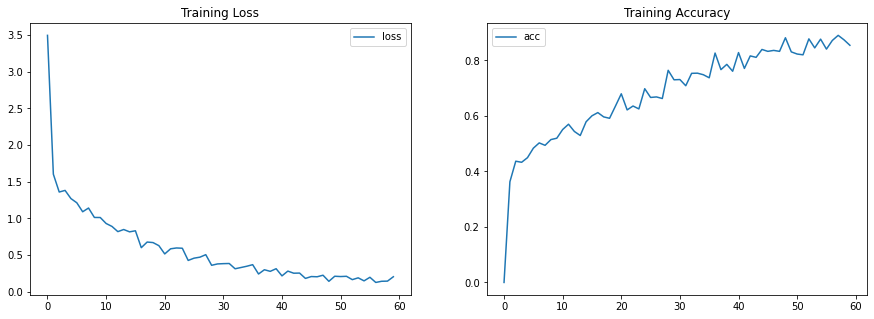

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def predict(input_text,input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

In [ ]:
predict(None,input_max_len,tokenizer_inputs, word2idx_outputs, idx2word_outputs)

i m the bad one .
[[  2  13  14 127  71   1   0   0]]
soy el malo . <eos>


In [ ]:
predict(input_data[17829],input_max_len,tokenizer_inputs, word2idx_outputs, idx2word_outputs)

i m not dead , am i ?
[[  2  13  33 302  49  59   2   5]]
no estoy muerto , ¿ no ? <eos>


In [ ]:
#Will use this in the new Decoder class

class LuongAttention(tf.keras.Model):
    def __init__(self, hidden_dim, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(hidden_dim) 
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(hidden_dim, activation='tanh')
            self.va = tf.keras.layers.Dense(1)


    def call(self,decoder_output,encoder_outputs):
      #We use the decoder output(hidden state) from one unit at a time & use it along with ALL encoder outputs 
      # Since we use all encoder outputs we are using Global Attention
      if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, hidden_dim)
            # encoder_outputs has shape: (batch_size, max_len, hidden_dim)
            score = tf.matmul(decoder_output, encoder_outputs, transpose_b=True) # (batch_size, 1, max_len)
            #So what does this mean? The score for each unit that we have in the encoder i.e encoder quality 
      elif self.attention_func == 'general':
          # General score function: decoder_output (dot) (Wa (dot) encoder_output)
          # Dense layer doesn't change dims of encoder_output since we use Dense(hidden_dim)
          # decoder_output has shape: (batch_size, 1, hidden_dim)
          # encoder_output has shape: (batch_size, max_len, hidden_dim)
          score = tf.matmul(decoder_output, self.wa(encoder_outputs), transpose_b=True) #(batch_size, 1, max_len)
      elif self.attention_func == 'concat':
          # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
          # Decoder output must be broadcasted to encoder output's shape first
          # tf.tile's second argument [1, encoder_output.shape[1], 1] basically multiplies 
          # decoder_output's current dimensions position wise by the numbers in the second argument
          decoder_output = tf.tile(decoder_output, [1, encoder_outputs.shape[1], 1]) #shape (batch size, max len,hidden_dim)

          # Concat => Wa => va
          # (batch_size, max_len, 2 * hidden_dim) => (batch_size, max_len, hidden_dim) => (batch_size, max_len, 1)

          score = self.va(self.wa(tf.concat((decoder_output, encoder_outputs), axis=-1))) # (batch_size, max len, 1)

          # Transpose score vector to have the same shape as other two above
          # (batch_size, max_len, 1) => (batch_size, 1, max_len)
          score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score), focuses where to pay attention in the sentence 
      alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
      
      # context vector c_t is the weighted average sum of encoder outputs, score the hidden states
      # since each encoder hidden states is most associated with a certain word in the input sentence
      #(batch_size, 1, max_len) X (batch_size, max_len , hidden_dim)
      context = tf.matmul(alignment, encoder_outputs) # (batch_size, 1, hidden_dim)

      return context, alignment


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, hidden_dim, attention_func):
    super(Decoder,self).__init__()
    self.attention = LuongAttention(hidden_dim, attention_func)
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True)
    self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
    self.ws = tf.keras.layers.Dense(vocab_size)

  def call(self,input_sequence_word,state_for_this_unit,encoder_outputs):
      # Remember that the input to the decoder
      # is now a batch of one-word sequences,
      # which means that its shape is (batch_size, 1)
      embed = self.embedding(input_sequence_word)

      # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
      lstm_out, state_h, state_c = self.lstm(embed, initial_state=state_for_this_unit)

      # Use self.attention to compute the context and alignment vectors
      # context vector's shape: (batch_size, 1, hidden_dim)
      # alignment vector's shape: (batch_size, 1, source_length)
      context, alignment = self.attention(lstm_out, encoder_outputs)

      # Combine the context vector and the LSTM output
      # Before combined, both have shape of (batch_size, 1, hidden_dim),
      # so let's squeeze the axis 1 first
      # After combined, it will have shape of (batch_size, 2 * hidden_dim)

      lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], axis=1)

      # lstm_out now has shape (batch_size, hidden_dim), because we passed it through a dense layer of size (hidden_dim)
      lstm_out = self.wc(lstm_out)

      # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
      logits = self.ws(lstm_out)

      return logits, state_h, state_c, alignment

In [ ]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of 2 arrays of shape [batch_size, hidden_dim] each.
            the initial state of the encoder for h & c state
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        #For attention for each word in the output we score all the encoder outputs
        # to see which ones we should pay attention to for our current word
        # Loop through all our words in our target sequence to see which words in the 
        # input sequence matter
        # Note that the decoder states (h & c) are getting updated after every unit predicts a logit
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, 1)
            # so we need to expand one dimension
            # as target_seq_in[:, i] gives us a shape (batch_size,)
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)

            #Passing all encoder outputs since we use GLOBAL ATTENTION

            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            # Adds a shape of 1 at position axis
            logit = K.expand_dims(logit, axis=1)

            #Now we need to concatenate logit max_len times to get logits for all the whole sequences in the batch
            #This concatenation needs to happen target_seq_out.shape[1] times
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1) 
        # After the loop logits' shape is batch_size,max_len,vocab_size

        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    #Normalise by max_len since we performed loss addition max_len times
    return loss / target_seq_out.shape[1], acc


In [ ]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 3.1812 Acc:0.0000
Epoch 1 Batch 100 Loss 1.4280 Acc:0.4260
Epoch 1 Batch 200 Loss 1.3252 Acc:0.4694
Epoch 1 Batch 300 Loss 1.1876 Acc:0.4970
Time taken for 1 epoch 63.9046 sec

Epoch 2 Batch 0 Loss 1.1672 Acc:0.4986
Epoch 2 Batch 100 Loss 1.1059 Acc:0.4986
Epoch 2 Batch 200 Loss 1.0303 Acc:0.5521
Epoch 2 Batch 300 Loss 0.9463 Acc:0.5629
Time taken for 1 epoch 45.3632 sec

Epoch 3 Batch 0 Loss 0.8610 Acc:0.5756
Epoch 3 Batch 100 Loss 0.8298 Acc:0.5718
Epoch 3 Batch 200 Loss 0.7408 Acc:0.6214
Epoch 3 Batch 300 Loss 0.8227 Acc:0.6103
Time taken for 1 epoch 44.6213 sec

Epoch 4 Batch 0 Loss 0.6127 Acc:0.6706
Epoch 4 Batch 100 Loss 0.6424 Acc:0.6182
Epoch 4 Batch 200 Loss 0.5868 Acc:0.6725
Epoch 4 Batch 300 Loss 0.6103 Acc:0.6676
Time taken for 1 epoch 45.2716 sec

Epoch 5 Batch 0 Loss 0.4458 Acc:0.7362
Epoch 5 Batch 100 Loss 0.4795 Acc:0.6805
Epoch 5 Batch 200 Loss 0.4697 Acc:0.7207
Epoch 5 Batch 300 Loss 0.4345 Acc:0.7400
Time taken for 1 epoch 44.4287 sec

Epoch 6 Ba

In [ ]:

def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    print(' '.join(out_words))
    return np.array(alignments), input_text.split(' '), out_words

she got him drunk .
ella se apresurada . <eos>
Alignmnets before squeezing
(5, 1, 1, 8)
['she', 'got', 'him', 'drunk', '.']
['ella', 'se', 'apresurada', '.', '<eos>']
Alignmnets after squeezing
(5, 8)


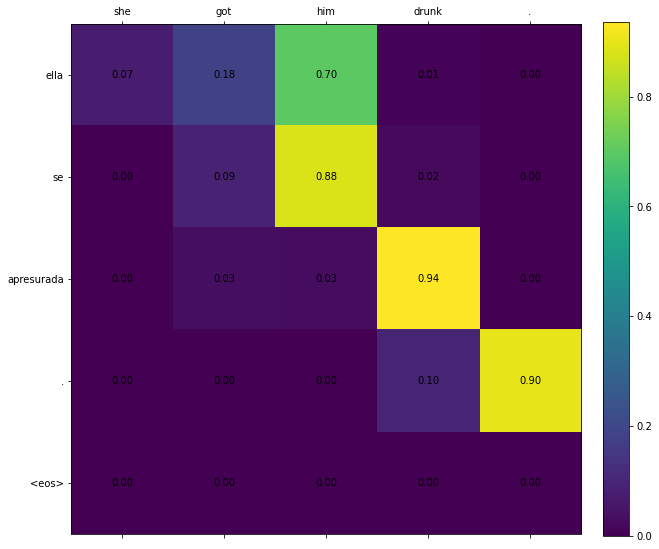

In [ ]:
n_predictions=1
test_sents = input_data[15005:(15005+n_predictions)]

# Create the figure to plot in
fig = plt.figure(figsize=(10, 20))
for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                     word2idx_outputs, idx2word_outputs)
    
    print("Alignmnets before squeezing")
    print(alignments.shape)
    attention = np.squeeze(alignments, (1, 2))

    print(source)
    print(prediction)

    print("Alignmnets after squeezing")
    print(attention.shape)

    


    # Create a subplot
    ax = fig.add_subplot(1, n_predictions, i+1)
    cax=ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
    fig.colorbar(cax,fraction=0.046, pad=0.04)

    ax.set_xticklabels([''] + source)
    ax.set_yticklabels([''] + prediction)

    for (i, j), z in np.ndenumerate(attention[:len(prediction), :len(source)]):
      ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

i m not dead , am i ?
no estoy muerto , ¿ no ? <eos>
Alignmnets before squeezing
(8, 1, 1, 8)
['i', 'm', 'not', 'dead', ',', 'am', 'i', '?']
['no', 'estoy', 'muerto', ',', '¿', 'no', '?', '<eos>']
Alignmnets after squeezing
(8, 8)


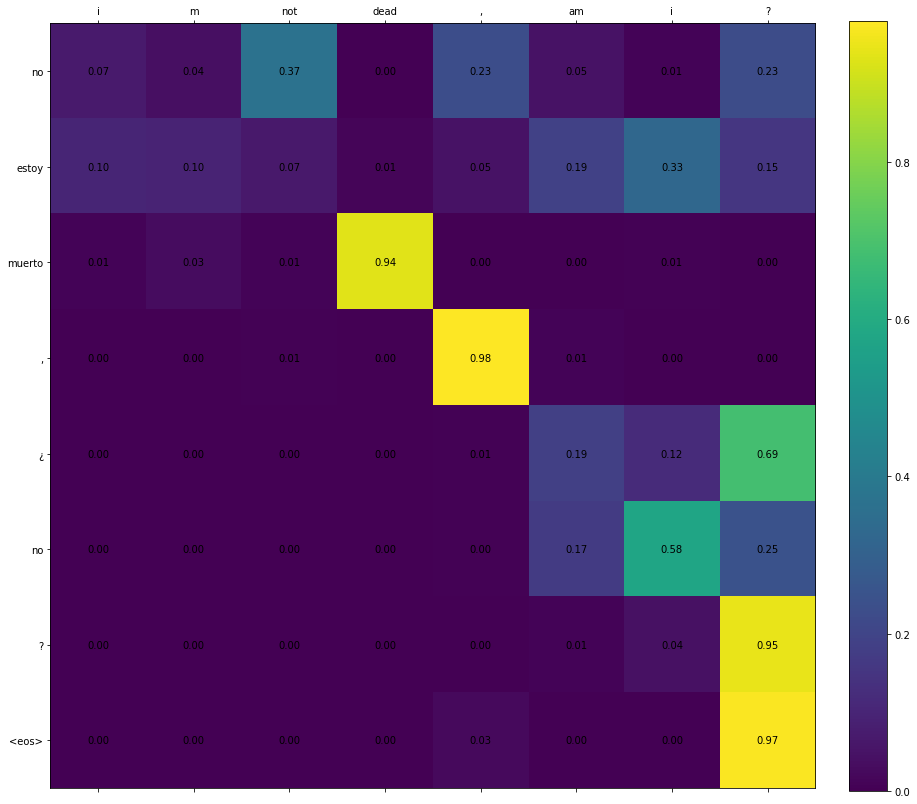

In [ ]:
n_predictions=1
test_sents = [input_data[17829]]

# Create the figure to plot in
fig = plt.figure(figsize=(15, 20))
for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                     word2idx_outputs, idx2word_outputs)
    
    print("Alignmnets before squeezing")
    print(alignments.shape)
    attention = np.squeeze(alignments, (1, 2))

    print(source)
    print(prediction)

    print("Alignmnets after squeezing")
    print(attention.shape)

    


    # Create a subplot
    ax = fig.add_subplot(1, n_predictions, i+1)
    cax=ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
    fig.colorbar(cax,fraction=0.046, pad=0.04)

    ax.set_xticklabels([''] + source)
    ax.set_yticklabels([''] + prediction)

    for (i, j), z in np.ndenumerate(attention[:len(prediction), :len(source)]):
      ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()